# Demonstration of linear mosaic

Reads a CASA MeasurementSet containing 7 pointing observation of CASA at 8.4 GHz, forms linear mosaic of dirty images

In [1]:
% matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

from data_models.parameters import arl_path

results_dir = arl_path('test_results')

from matplotlib import pylab

import numpy

from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from data_models.polarisation import PolarisationFrame

from data_models.parameters import arl_path

from libs.image.iterators import image_raster_iter

from processing_components.visibility.base import create_visibility, create_visibility_from_ms
from processing_components.skycomponent.operations import create_skycomponent
from processing_components.image.operations import show_image, copy_image
from processing_components.image.deconvolution import deconvolve_cube
from processing_components.visibility.iterators import vis_timeslice_iter
from processing_components.simulation.testing_support import create_named_configuration
from processing_components.imaging.primary_beams import create_pb
from processing_components.imaging.base import create_image_from_visibility, invert_2d
from processing_components.imaging.weighting import weight_visibility

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))


backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'Greys'

In [3]:
vis_list=create_visibility_from_ms(arl_path('data/vis/xcasa.ms'))

Successful readonly open of default-locked table /Users/timcornwell/Code/algorithm-reference-library/data/vis/xcasa.ms: 23 columns, 204736 rows
create_visibility_from_ms: {'type': 'Measurement Set', 'subType': 'UVFITS', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\nThis is a measurement set Table holding astronomical observations\n'}


create_visibility_from_ms: Found unique field ids [0 1 2 3 4 5 6]


create_visibility_from_ms: Found 57108 rows for field 0


create_visibility_from_ms: Found 1 channels


create_visibility_from_ms: polarisation circular


create_visibility_from_ms: Found 29680 rows for field 1


create_visibility_from_ms: Found 1 channels


create_visibility_from_ms: polarisation circular
create_visibility_from_ms: Found 24094 rows for field 2


create_visibility_from_ms: Found 1 channels


create_visibility_from_ms: polarisation circular
create_visibility_from_ms: Found 23628 rows for field 3


create_visibility_from_ms: Found 1 channels


create_visibility_from_ms: polarisation circular
create_visibility_from_ms: Found 23716 rows for field 4


create_visibility_from_ms: Found 1 channels


create_visibility_from_ms: polarisation circular
create_visibility_from_ms: Found 23364 rows for field 5


create_visibility_from_ms: Found 1 channels


create_visibility_from_ms: polarisation circular
create_visibility_from_ms: Found 23146 rows for field 6


create_visibility_from_ms: Found 1 channels


create_visibility_from_ms: polarisation circular


findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/timcornwell/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/timcornwell/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


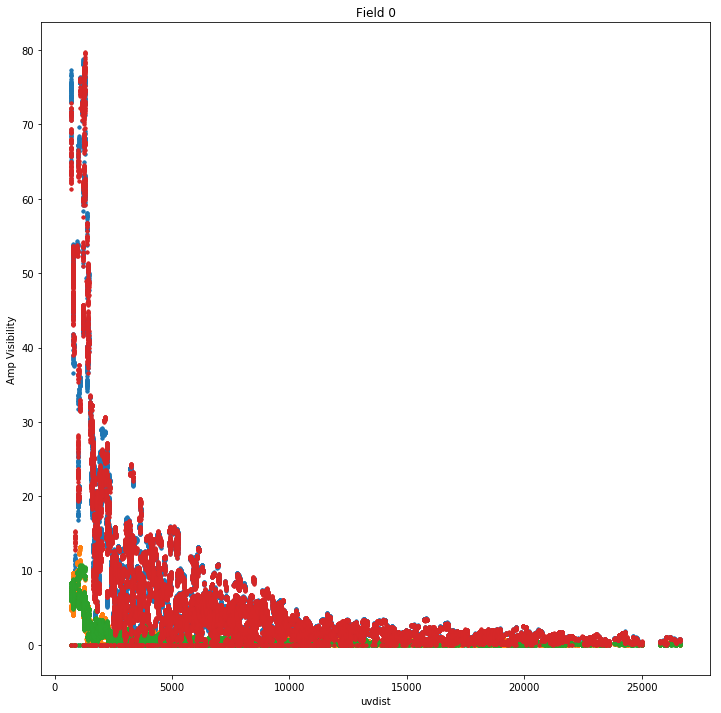

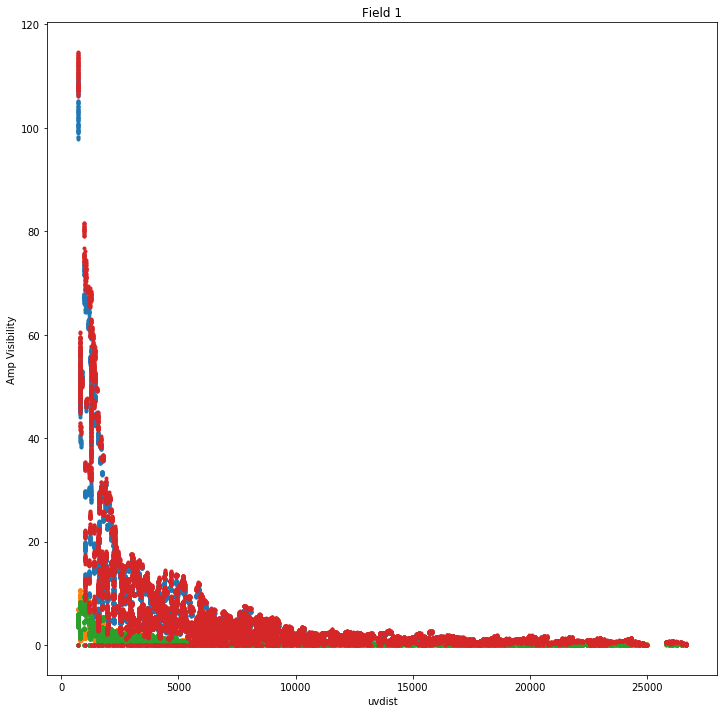

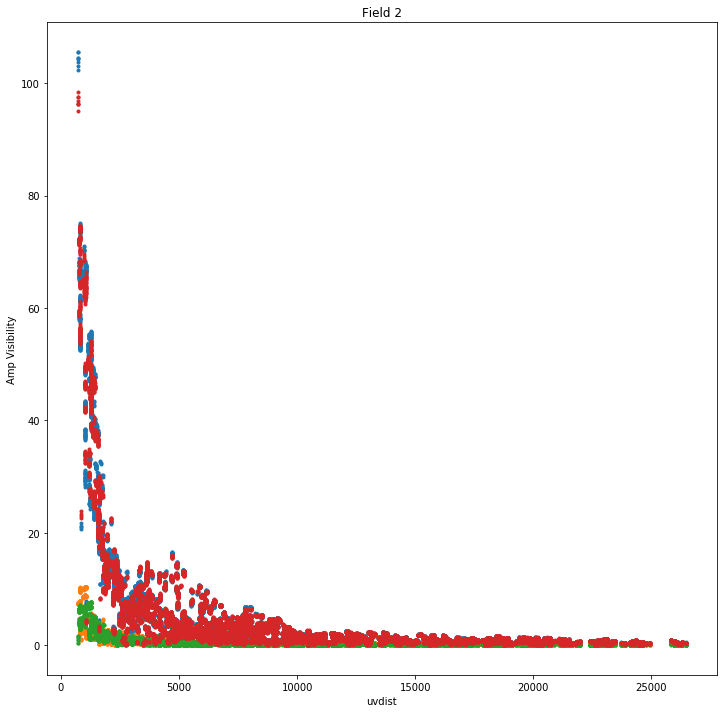

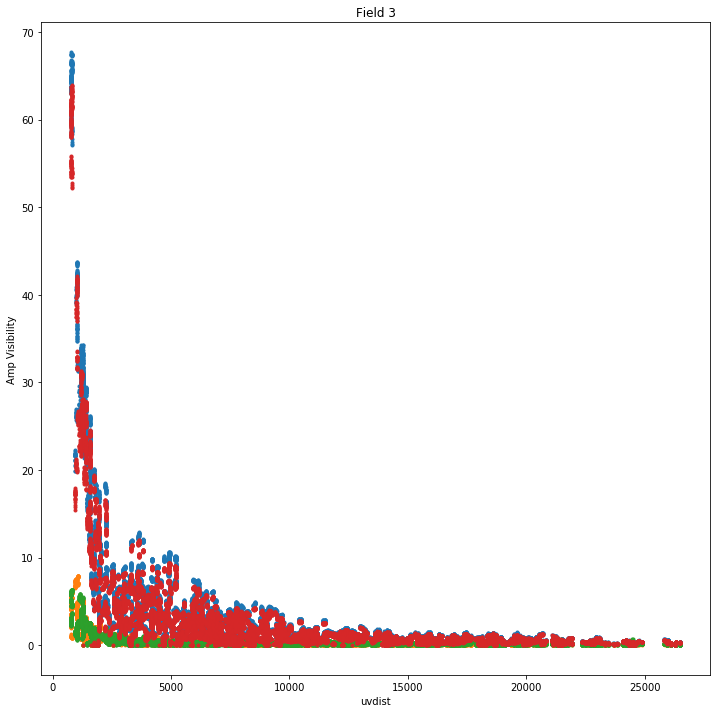

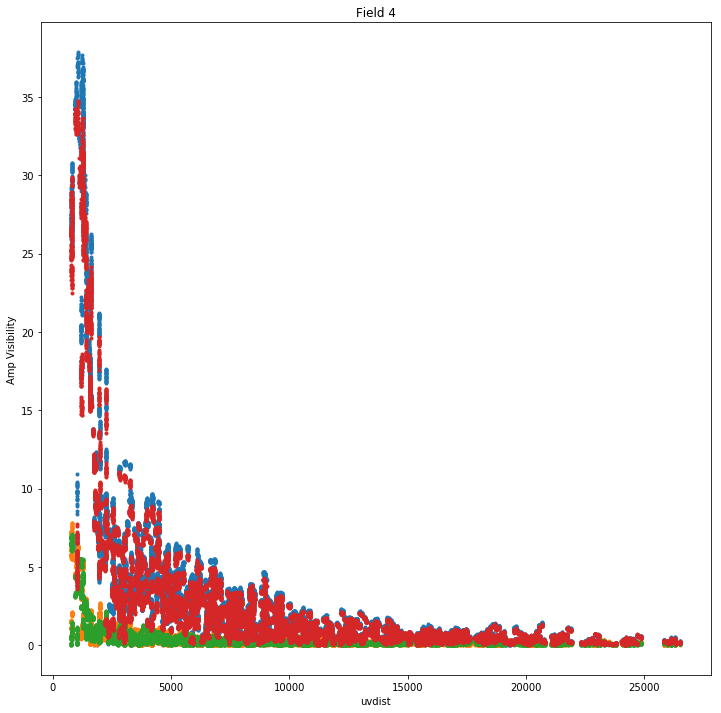

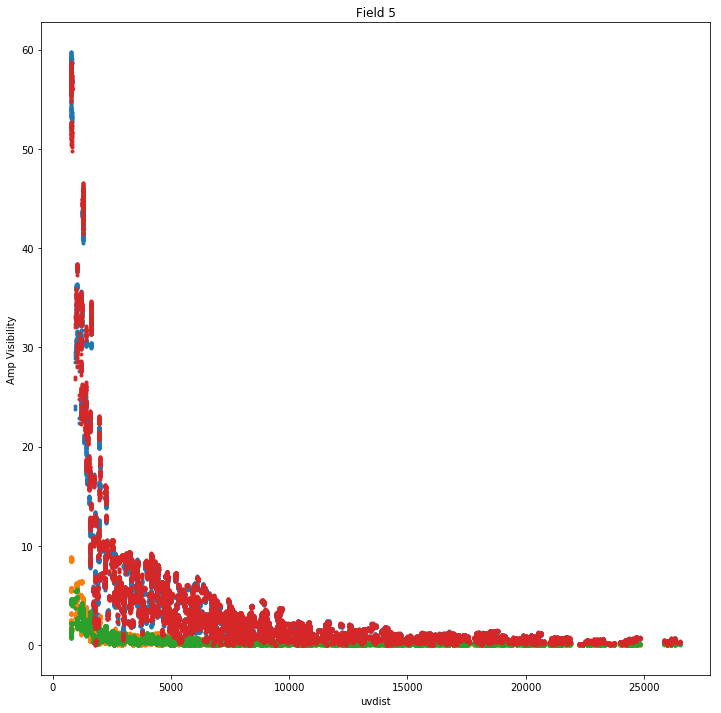

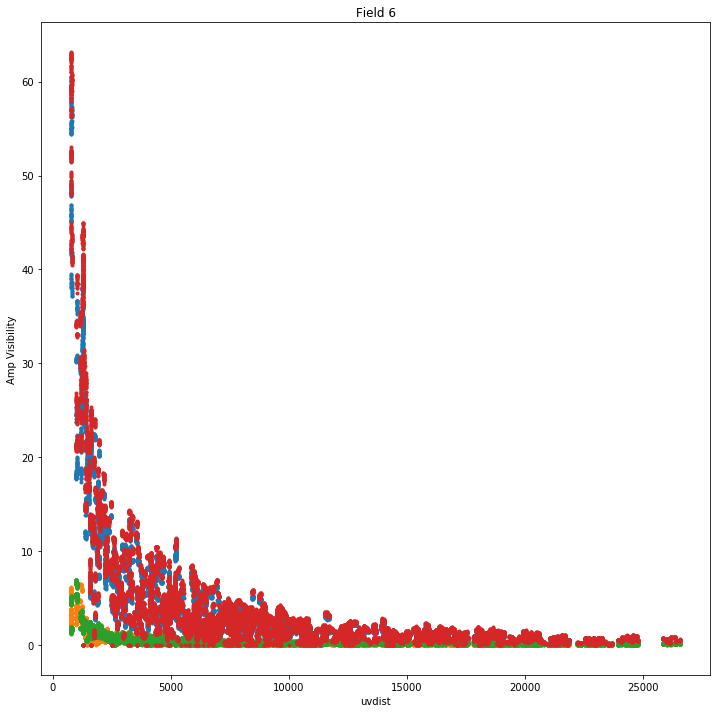

In [4]:
# plot the amplitude of the visibility for each field
for field, vt in enumerate(vis_list):
    uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
    plt.clf()
    plt.plot(uvdist, numpy.abs(vt.data['vis']), '.')
    plt.xlabel('uvdist')
    plt.ylabel('Amp Visibility')
    plt.title('Field %d' % (field))
    plt.show()

Make the dirty images

create_image_from_visibility: Parsing parameters to get definition of WCS


create_image_from_visibility: Defining 2 channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    [(350.30416667, 58.54305556)]>, starting frequency 8435100000.0 Hz, and bandwidth 49999999.9995 Hz


create_image_from_visibility: uvmax = 17595.988353 wavelengths


create_image_from_visibility: Critical cellsize = 0.000028 radians, 0.001628 degrees


create_image_from_visibility: Cellsize          = 0.000010 radians, 0.000573 degrees


shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    [(350.21, 58.54305556)]> to image phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (350.30416667, 58.54305556)>


shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    [(350.25708333, 58.5875)]> to image phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (350.30416667, 58.54305556)>


shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    [(350.35125, 58.5875)]> to image phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (350.30416667, 58.54305556)>


shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    [(350.39833333, 58.54305556)]> to image phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (350.30416667, 58.54305556)>


shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    [(350.35125, 58.49972222)]> to image phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (350.30416667, 58.54305556)>


shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    [(350.25708333, 58.49972222)]> to image phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (350.30416667, 58.54305556)>


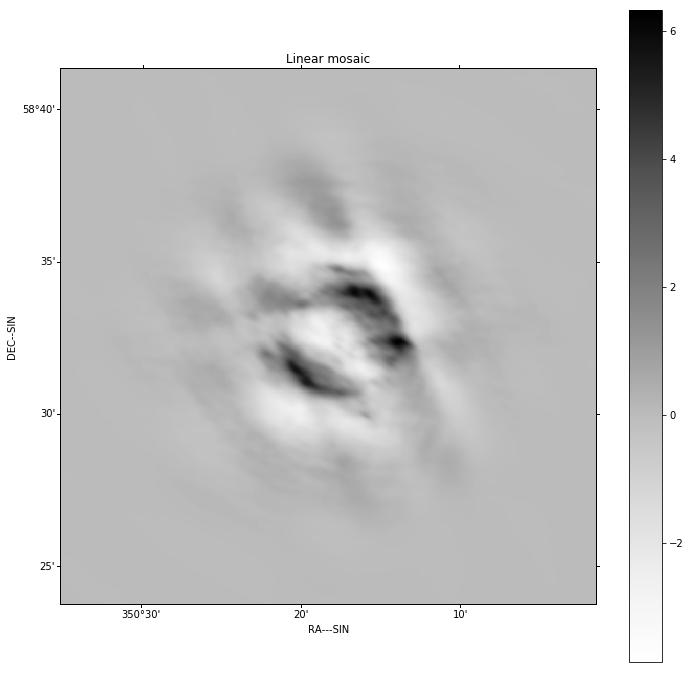

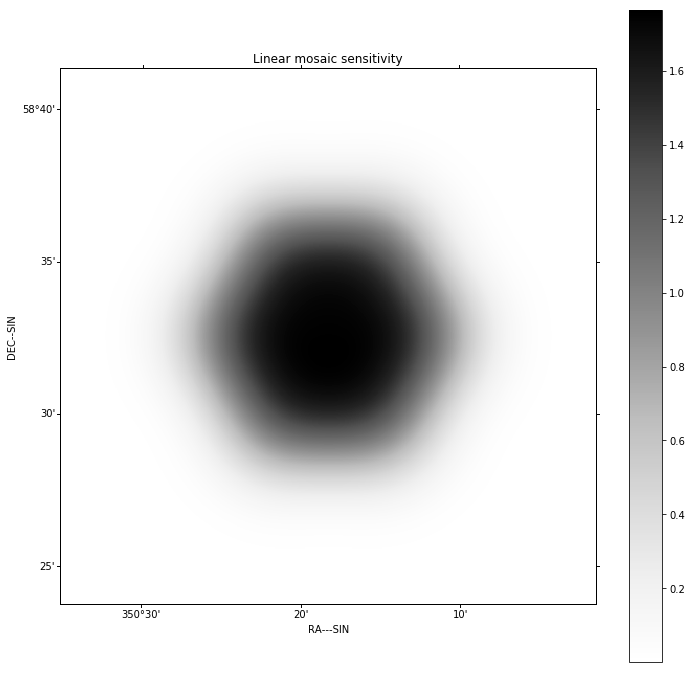

In [6]:
cellsize=0.00001

model = create_image_from_visibility(vis_list[0], cellsize=cellsize, npixel=512, nchan=2, 
                                     imagecentre=vis_list[0].phasecentre,
                                     polarisation_frame=PolarisationFrame('stokesIQUV'))
mosaic = copy_image(model)
mosaicsens = copy_image(model)
work = copy_image(model)

for vt in vis_list:
    beam = create_pb(model, telescope='VLA', pointingcentre=vt.phasecentre)
    beam.data /= numpy.max(beam.data)
    dirty, sumwt = invert_2d(vt, model)
    mosaic.data += dirty.data * beam.data
    mosaicsens.data += beam.data**2
    
show_image(mosaic, cm='Greys', title='Linear mosaic')
plt.show()
show_image(mosaicsens, cm='Greys', title='Linear mosaic sensitivity')
plt.show()
